In [ ]:
# training: 1st march to 24th march for weights
# caluclation day: previous 5 days from the prediction day
# upload files from 1st march to 29th march

In [ ]:
import os
import csv
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

data_dir = "/content/"
weight = [0.2] * 5  # Initial weights


In [ ]:
# --- Utility Functions ---
def load_data(files):
    data = {}
    for file in files:
        try:
            with open(file, 'r') as f:
                reader = csv.DictReader(f)
                data[file] = [float(row['load']) for row in reader]
        except Exception as e:
            print(f"Error reading {file}: {e}")
            data[file] = []
    return data


def get_min_max(files):
    all_loads = []
    for file in files:
        df = pd.read_csv(file)
        all_loads.extend(df['load'].tolist())
    return min(all_loads), max(all_loads)


def normalize(values, min_val, max_val):
    return [(v - min_val) / (max_val - min_val) for v in values]


def denormalize(values, min_val, max_val):
    return [v * (max_val - min_val) + min_val for v in values]



In [ ]:
# --- Gradient Descent Training ---
def gradient_descent(data_dict, dates, weight):
    epochs = 8000
    lr = 1e-2
    n = min(len(data_dict[date]) for date in dates)

    for epoch in range(1, epochs + 1):
        grad = [0.0] * len(weight)
        loss = 0.0
        total_blocks = (len(dates) - len(weight)) * n

        for block in range(n):
            for i in range(len(weight), len(dates)):
                forecast_val = 0.0
                for k in range(len(weight)):
                    forecast_val += data_dict[dates[i - k - 1]][block] * weight[k]
                error = forecast_val - data_dict[dates[i]][block]
                loss += (error ** 2) / (2 * total_blocks)
                for k in range(len(weight)):
                    grad[k] += (error * data_dict[dates[i - k - 1]][block]) / total_blocks

        for k in range(len(weight)):
            weight[k] -= lr * grad[k]

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss:.6f}, Weights: {weight}")
    return weight



In [ ]:
# --- Predict for a given day using WMA ---
def predict_day(day, weight, min_val, max_val):
    input_files = []
    for i in range(5):
        date = datetime.strptime(day, "%Y-%m-%d") - timedelta(days=5 - i)
        input_file = os.path.join(data_dir, f"{date.date()}_predicted.csv")
        if not os.path.exists(input_file):
            input_file = os.path.join(data_dir, f"{date.date()}.csv")  # fallback to actual
        input_files.append(input_file)

    data = []
    for file in input_files:
        df = pd.read_csv(file)
        load = df['load'].values
        norm = normalize(load, min_val, max_val)
        data.append(norm)

    input_array = np.array(data)  # shape (5, 96)

    prediction_norm = []
    for block in range(96):
        pred = sum(weight[i] * input_array[4 - i][block] for i in range(5))
        prediction_norm.append(pred)

    prediction = denormalize(prediction_norm, min_val, max_val)

    base_time = datetime.strptime(day + " 00:00:00", "%Y-%m-%d %H:%M:%S")
    date_times = [base_time + timedelta(minutes=15 * i) for i in range(96)]

    output_df = pd.DataFrame({
        "date_time": [dt.strftime("%Y-%m-%d %H:%M:%S") for dt in date_times],
        "load": prediction
    })

    save_path = os.path.join(data_dir, f"{day}_predicted.csv")
    output_df.to_csv(save_path, index=False)
    print(f"✅ Saved prediction for {day} ➤ {save_path}")
    return prediction


In [ ]:
# --- Evaluate Predictions ---
def evaluate_prediction(predicted, actual_file):
    actual_df = pd.read_csv(actual_file)
    actual = actual_df['load'].values
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    print(f"📊 Evaluation for {actual_file}")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")
    return actual, mae, rmse, mape


In [ ]:
def main():
    # Step 1: Train Model
    train_files = [os.path.join(data_dir, f"2025-03-{day:02d}.csv") for day in range(1, 25)]
    min_val, max_val = get_min_max(train_files)
    raw_data = load_data(train_files)
    norm_data = {k: normalize(v, min_val, max_val) for k, v in raw_data.items()}
    weights = gradient_descent(norm_data, train_files, weight)

    # To store metrics
    metric_results = {'date': [], 'MAE': [], 'RMSE': [], 'MAPE': []}

    # Step 2: Predict Days Sequentially using Predicted Files
    for day in ["2025-03-25", "2025-03-26", "2025-03-27", "2025-03-28", "2025-03-29"]:
        pred = predict_day(day, weights, min_val, max_val)
        actual_file = os.path.join(data_dir, f"{day}.csv")
        actual, mae, rmse, mape = evaluate_prediction(pred, actual_file)

        # Save metrics
        metric_results['date'].append(day)
        metric_results['MAE'].append(mae)
        metric_results['RMSE'].append(rmse)
        metric_results['MAPE'].append(mape)

        # Optional Plot
        time_labels = pd.to_datetime(pd.read_csv(actual_file)['date_time'])
        plt.figure(figsize=(15, 5))
        plt.plot(time_labels, actual, label='Actual', linewidth=2)
        plt.plot(time_labels, pred, label='Predicted', linestyle='--', linewidth=2)
        plt.title(f"Load Forecasting for {day}")
        plt.xlabel("Time")
        plt.ylabel("Load (MW)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print('-' * 100)

    # --- Plot MAE and RMSE ---
    plt.figure(figsize=(10, 5))
    plt.plot(metric_results['date'], metric_results['MAE'], marker='o', label='MAE')
    plt.plot(metric_results['date'], metric_results['RMSE'], marker='s', label='RMSE')
    plt.title("MAE and RMSE vs Prediction Date (WMA GD)")
    plt.xlabel("Prediction Date")
    plt.ylabel("Error Value (MW)")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print('-' * 100)

    # --- Plot MAPE separately ---
    plt.figure(figsize=(10, 5))
    plt.plot(metric_results['date'], metric_results['MAPE'], marker='^', color='purple', label='MAPE')
    plt.title("MAPE vs Prediction Date (WMA GD)")
    plt.xlabel("Prediction Date")
    plt.ylabel("MAPE (%)")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Epoch 1, Loss: 0.004877, Weights: [0.1999284725328964, 0.19990256311188523, 0.19989324695461588, 0.1998866733454867, 0.19989345784432094]
Epoch 100, Loss: 0.004728, Weights: [0.1979176551907429, 0.19545211399237297, 0.19453940703617292, 0.19381095624619654, 0.19445846214588206]
Epoch 200, Loss: 0.004713, Weights: [0.19968200349741524, 0.1948572861713334, 0.19305085203122277, 0.19154359169641658, 0.192814473308993]
Epoch 300, Loss: 0.004703, Weights: [0.20211664394527842, 0.19496603913695057, 0.1922752713829044, 0.18998512234654452, 0.1918743057445918]
Epoch 400, Loss: 0.004694, Weights: [0.2046542821778524, 0.1951979131107938, 0.1916304421301295, 0.18856155396772564, 0.19106736382505238]
Epoch 500, Loss: 0.004684, Weights: [0.20719371205363352, 0.1954492398845131, 0.19101233080756017, 0.18717028475213054, 0.1902916473566139]
Epoch 600, Loss: 0.004675, Weights: [0.20971698806501127, 0.19570152480525027, 0.1904023276523327, 0.18579292267665495, 0.18952886636516522]
Epoch 700, Loss: 0.004

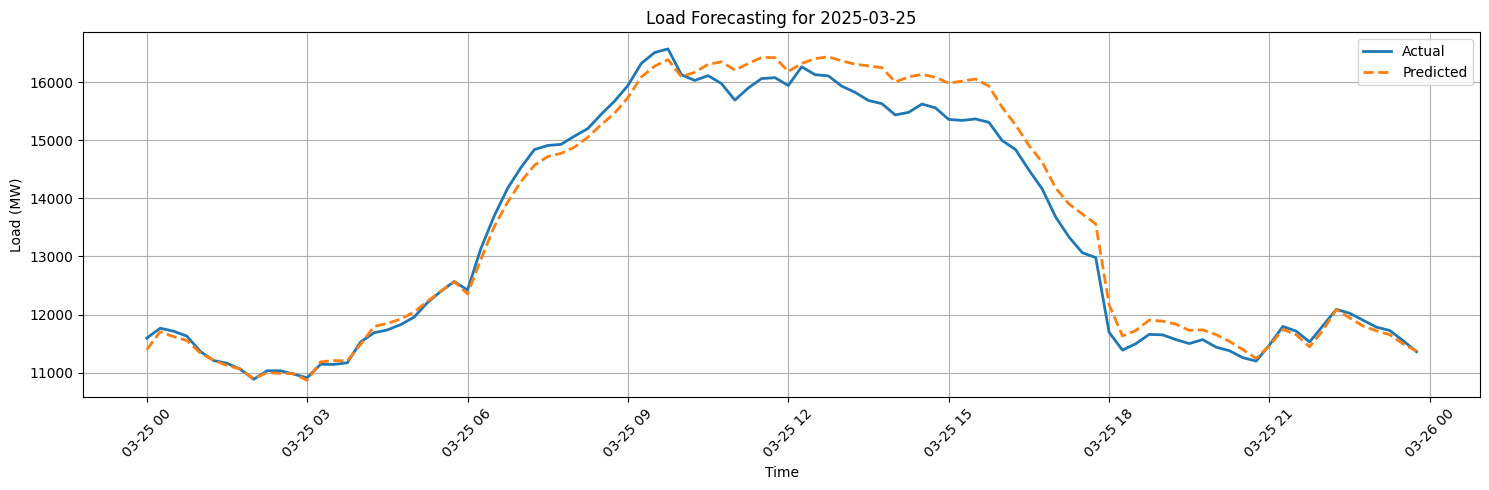

✅ Saved prediction for 2025-03-26 ➤ /content/2025-03-26_predicted.csv
📊 Evaluation for /content/2025-03-26.csv
MAE  : 225.30
RMSE : 290.99
MAPE : 1.73%


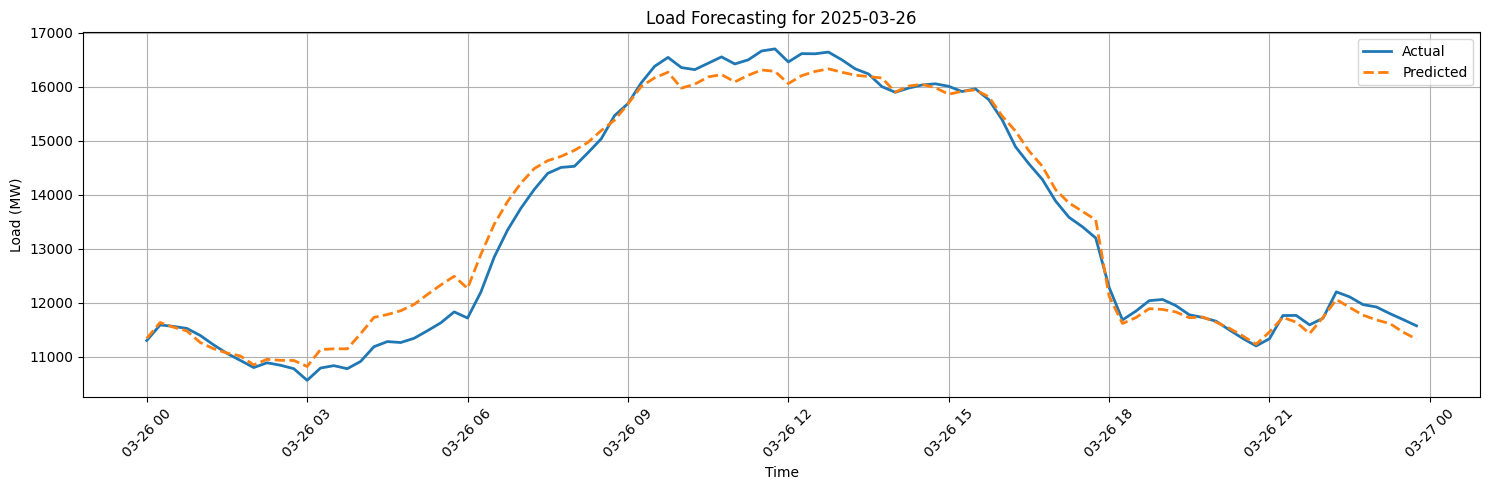

✅ Saved prediction for 2025-03-27 ➤ /content/2025-03-27_predicted.csv
📊 Evaluation for /content/2025-03-27.csv
MAE  : 456.95
RMSE : 553.01
MAPE : 3.40%


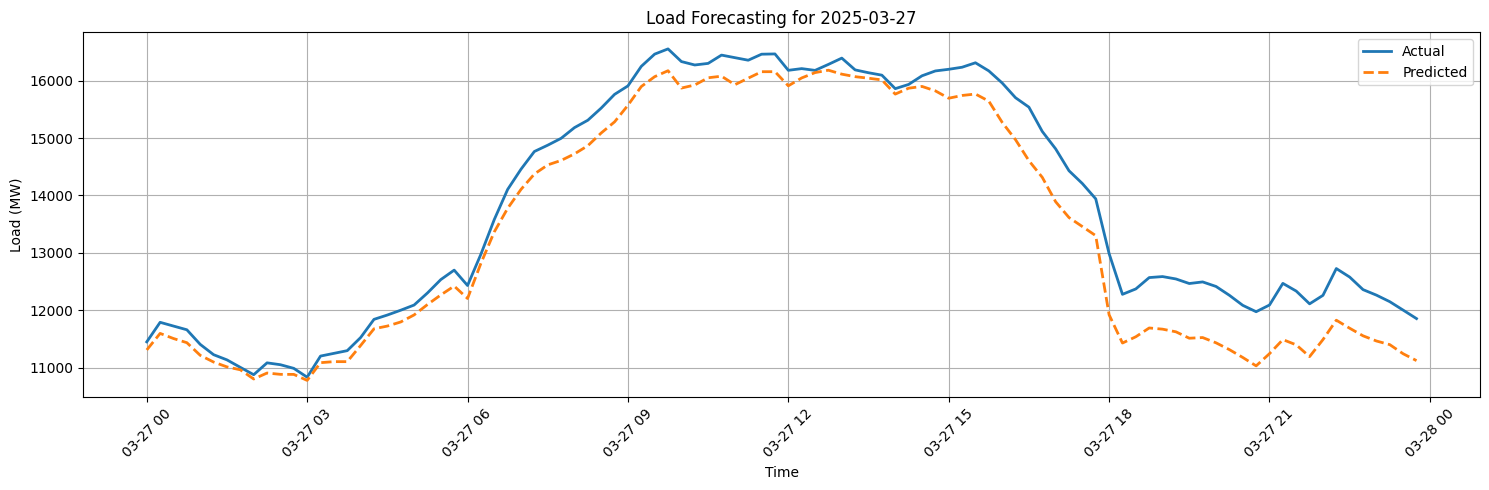

✅ Saved prediction for 2025-03-28 ➤ /content/2025-03-28_predicted.csv
📊 Evaluation for /content/2025-03-28.csv
MAE  : 910.55
RMSE : 946.87
MAPE : 6.47%


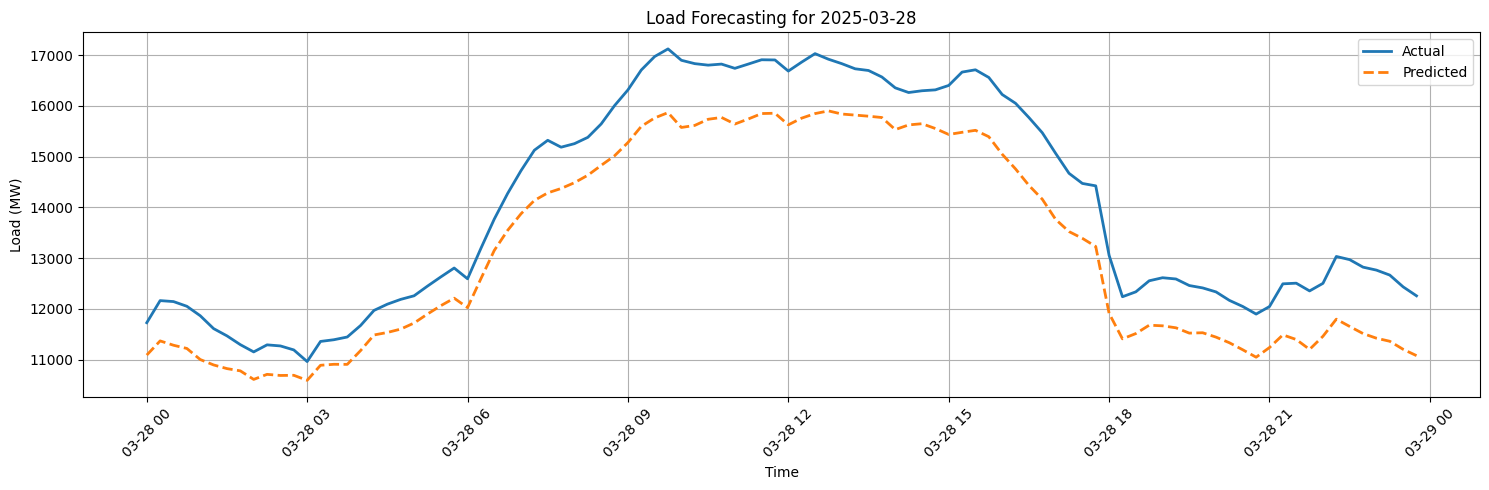

✅ Saved prediction for 2025-03-29 ➤ /content/2025-03-29_predicted.csv
📊 Evaluation for /content/2025-03-29.csv
MAE  : 833.97
RMSE : 893.53
MAPE : 6.06%


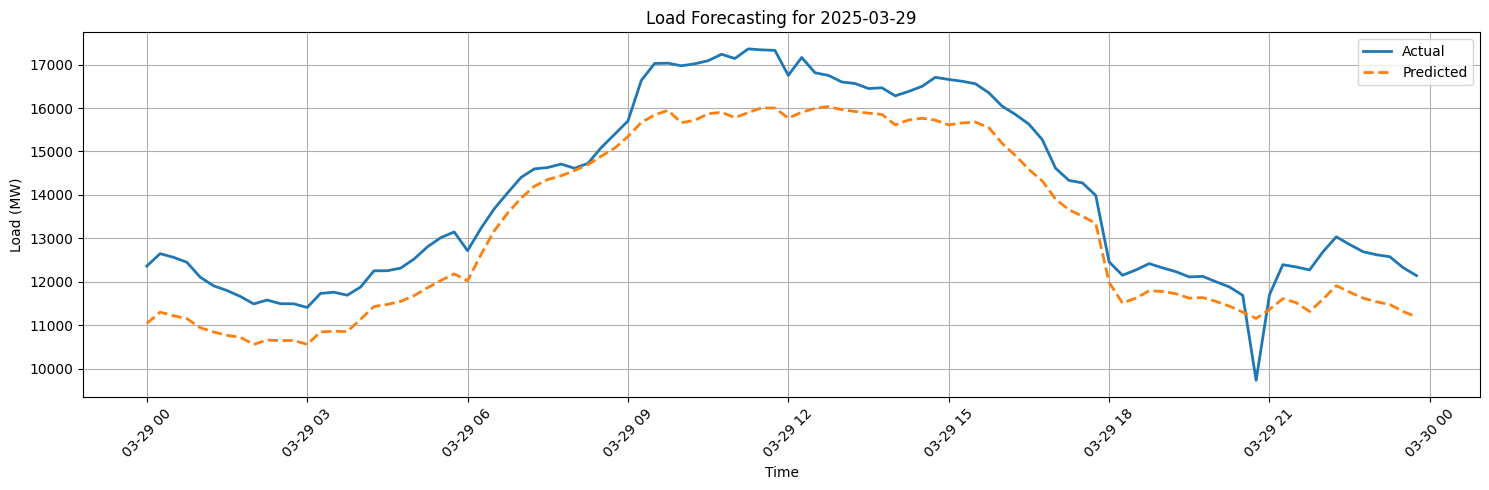

----------------------------------------------------------------------------------------------------


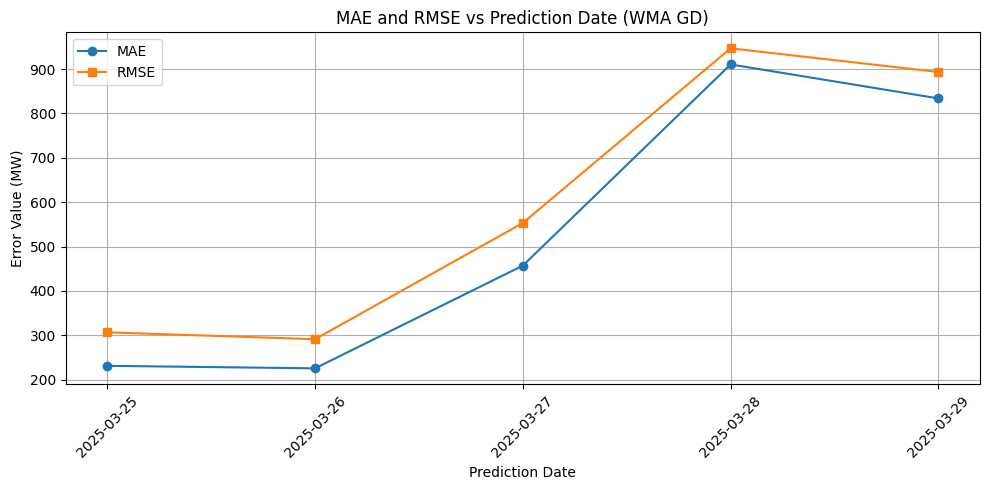

----------------------------------------------------------------------------------------------------


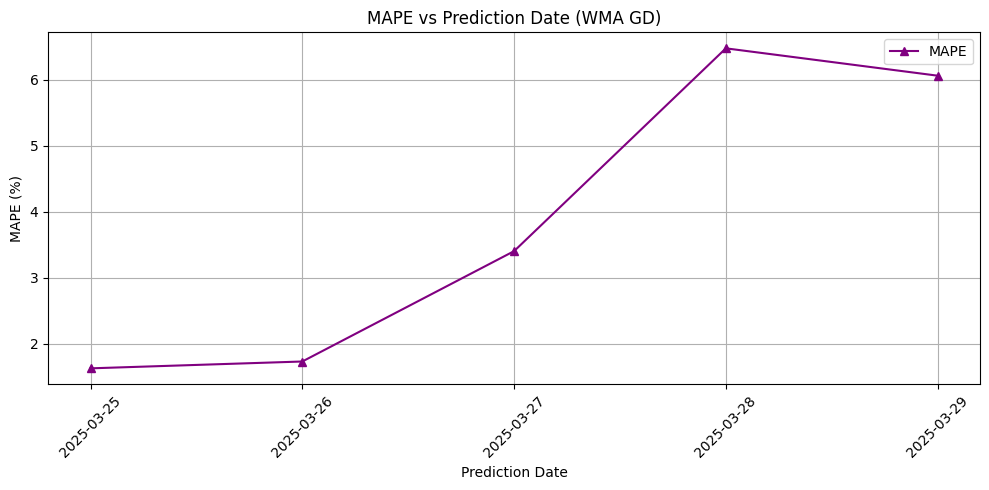

In [7]:
if __name__ == "__main__":
    main()